## Imports

In [1]:
import config
import utils.cleaning as cl
import visual.plot as vplot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
df = pd.read_csv("data/covid/france/chiffres-cles-18-06.csv", sep=",")

In [3]:
df.columns

Index(['date', 'granularite', 'maille_code', 'maille_nom', 'cas_confirmes',
       'cas_ehpad', 'cas_confirmes_ehpad', 'cas_possibles_ehpad', 'deces',
       'deces_ehpad', 'reanimation', 'hospitalises',
       'nouvelles_hospitalisations', 'nouvelles_reanimations', 'gueris',
       'depistes', 'source_nom', 'source_url', 'source_archive',
       'source_type'],
      dtype='object')

In [4]:
df.dtypes

date                           object
granularite                    object
maille_code                    object
maille_nom                     object
cas_confirmes                 float64
cas_ehpad                     float64
cas_confirmes_ehpad           float64
cas_possibles_ehpad           float64
deces                         float64
deces_ehpad                   float64
reanimation                   float64
hospitalises                  float64
nouvelles_hospitalisations    float64
nouvelles_reanimations        float64
gueris                        float64
depistes                      float64
source_nom                     object
source_url                     object
source_archive                 object
source_type                    object
dtype: object

In [19]:
df.iloc[0]

date                                                                 2020-01-24
granularite                                                                pays
maille_code                                                                 FRA
maille_nom                                                               France
cas_confirmes                                                                 3
cas_ehpad                                                                   NaN
cas_confirmes_ehpad                                                         NaN
cas_possibles_ehpad                                                         NaN
deces                                                                         0
deces_ehpad                                                                 NaN
reanimation                                                                 NaN
hospitalises                                                                  3
nouvelles_hospitalisations              

## Cleaning

In [6]:
df = cl.keep_only_france(df)
df[["date", "cas_confirmes", "source_nom"]]

,date,cas_confirmes,source_nom
13,2020-01-24,3.0,Santé publique France
14,2020-01-24,3.0,Ministère des Solidarités et de la Santé
22,2020-01-25,3.0,Santé publique France
27,2020-01-26,3.0,Santé publique France
33,2020-01-27,3.0,Santé publique France
...,...,...,...
14020,2020-06-15,NaN,OpenCOVID19-fr
14140,2020-06-16,157716.0,Ministère des Solidarités et de la Santé
14141,2020-06-16,NaN,OpenCOVID19-fr
14261,2020-06-17,158174.0,Ministère des Solidarités et de la Santé


Il y a des valeurs NAN selon les sources, on souhaite savoir s'il y a des données conflictuelles

In [7]:
cl.print_conflictual_information(df)

2020-02-07
91    11.0
92     6.0
Name: cas_confirmes, dtype: float64
2020-02-25
157    12.0
158    14.0
Name: cas_confirmes, dtype: float64
2020-02-26
170    17.0
171    18.0
Name: cas_confirmes, dtype: float64
2020-02-28
194    38.0
195    57.0
Name: cas_confirmes, dtype: float64
2020-02-29
231     73.0
232    100.0
Name: cas_confirmes, dtype: float64
2020-03-02
270    178.0
271    191.0
Name: cas_confirmes, dtype: float64
2020-03-14
1603    4499.0
1604    4500.0
Name: cas_confirmes, dtype: float64


On trouve quelques cas conflictuels. Pour résoudre le souci on prendra la valeur maximum des deux à chaque fois. On supprime donc toutes les lignes à cas confirmes NAN, et pour les cas à plusieurs sources on prendra la première.

In [8]:
cas_confirmes_df = cl.drop_NA_confirmed_cases(df)

In [9]:
evolution_par_jour = cl.keep_only_first_row_by_date(cas_confirmes_df)

In [10]:
evolution_par_jour = cas_confirmes_df.groupby("date", as_index=False).first()

On calcule la colonne de la population non malade.

In [11]:
population_FR = 67000000
evolution_par_jour["susceptible"] = population_FR - (evolution_par_jour["cas_confirmes"] +\
                                                     evolution_par_jour["deces"] + evolution_par_jour["gueris"])

## Plots

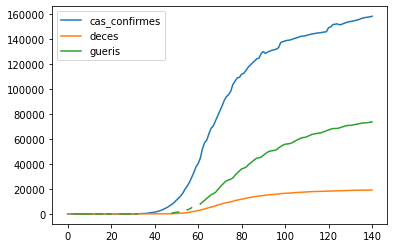

In [12]:
vplot.plot_CDG(evolution_par_jour)

Il y a encore des valeurs NAN dans la colonne des guéris, d'où les petits trous par endroits.

In [13]:
evolution_par_jour = cl.interpolate_nan(evolution_par_jour, "gueris")

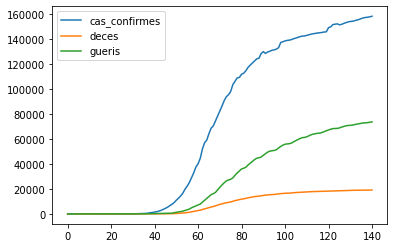

In [14]:
vplot.plot_CDG(evolution_par_jour)

### plot type model SIR

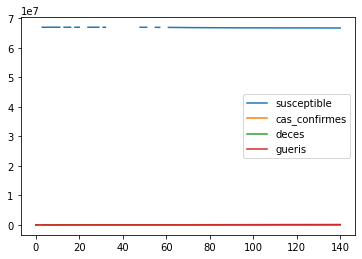

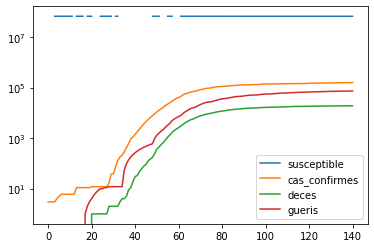

In [15]:
vplot.plot_SCDG(evolution_par_jour)
vplot.plot_SCDG(evolution_par_jour, logy=True)

La proportion de malades par rapport à la population totale est trop petite pour voir une évolution comme un modèle SIR classique.

## export csv

In [16]:
evolution_par_jour.to_csv("data/covid/france/evolution_par_jour_18_06.csv")